# EKF Analysis

En este análisis, se ha utilizado un Filtro de Kalman Extendido (EKF) para estimar la posición y orientación de un vehículo en un escenario específico. A continuación, se detallan los pasos y resultados obtenidos:

### Carga de Datos

Se han cargado dos archivos CSV que contienen los datos de las poses y los puntos de referencia (landmarks) del escenario. Estos archivos se han leído utilizando la librería `pandas`.

### Visualización de Datos

Se han visualizado las primeras filas y la información general de los datos de poses y landmarks para entender mejor su estructura y contenido.

### Preprocesamiento de Datos

Se han convertido las columnas `frame` y `match_index` a valores numéricos y se ha creado una nueva columna `match` en `poses_data` para indicar si hay una coincidencia con los puntos de referencia.

### Recorridos

Se han graficado las componentes X, Y y Yaw de las posiciones reales y corregidas a lo largo de los frames, destacando los puntos donde hay coincidencias con los landmarks.

### Errores de Posición y Orientación

Se han calculado los errores cuadráticos medios (MSE) para las posiciones y orientaciones estimadas en comparación con las reales.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
import os
import sys

In [19]:
# Load the files
scene = "individual_files_validation_segment-10289507859301986274_4200_000_4220_000_with_camera_labels"
date = "202503151657"

# filepath of the csv file with the scene poses_data
poses_file_path = os.path.join(os.getcwd(), scene + "/" + date, "poses_" + scene + ".csv")
landmarks_file_path = os.path.join(os.getcwd(), scene + "/" + date, "landmarks_" + scene + ".csv")
print("Poses File Path:", poses_file_path)
print("Landmarks File Path:", landmarks_file_path)


Poses File Path: /home/rodrigo/catkin_ws/src/TFM_Landmark_Based_Localization/results/individual_files_validation_segment-10289507859301986274_4200_000_4220_000_with_camera_labels/202503151657/poses_individual_files_validation_segment-10289507859301986274_4200_000_4220_000_with_camera_labels.csv
Landmarks File Path: /home/rodrigo/catkin_ws/src/TFM_Landmark_Based_Localization/results/individual_files_validation_segment-10289507859301986274_4200_000_4220_000_with_camera_labels/202503151657/landmarks_individual_files_validation_segment-10289507859301986274_4200_000_4220_000_with_camera_labels.csv


Lee información de las Poses con Pandas para visualizarlas

In [20]:
poses_data = pd.read_csv(poses_file_path)
poses_data.shape

(198, 19)

In [21]:
poses_data.head()

,frame,real_x,real_y,real_z,real_roll,real_pitch,real_yaw,odometry_x,odometry_y,odometry_z,odometry_roll,odometry_pitch,odometry_yaw,corrected_x,corrected_y,corrected_z,corrected_roll,corrected_pitch,corrected_yaw
0,[1],0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.024079,-0.008622,0.000000,0.000000,-0.000000,0.000000
1,[2],0.499197,-0.000814,0.001915,-0.001897,0.000956,-0.000485,0.480184,-0.050393,0.001915,-0.001897,0.000956,0.001007,0.521600,-0.125806,0.001757,-0.001407,0.000478,0.001986
2,[3],0.999919,-0.000109,0.001884,-0.001714,0.001724,-0.000298,0.962390,-0.000255,0.001809,-0.001720,0.001711,-0.005447,1.020919,-0.062031,0.002459,-0.000657,0.000818,-0.005253
3,[4],1.503178,-0.002239,0.000974,-0.001346,0.001439,0.000087,1.455405,-0.183714,0.001229,-0.001353,0.001425,-0.005442,1.513970,-0.245395,0.002128,-0.000290,0.000532,-0.005248
4,[5],2.008165,-0.001622,-0.000880,0.001051,0.001055,0.000089,1.916613,-0.174151,-0.000571,0.001043,0.001041,-0.005841,1.975178,-0.235741,0.000752,0.002106,0.000148,-0.005648


In [22]:
poses_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   frame            198 non-null    object 
 1   real_x           198 non-null    float64
 2   real_y           198 non-null    float64
 3   real_z           198 non-null    float64
 4   real_roll        198 non-null    float64
 5   real_pitch       198 non-null    float64
 6   real_yaw         198 non-null    float64
 7   odometry_x       198 non-null    float64
 8   odometry_y       198 non-null    float64
 9   odometry_z       198 non-null    float64
 10  odometry_roll    198 non-null    float64
 11  odometry_pitch   198 non-null    float64
 12  odometry_yaw     198 non-null    float64
 13  corrected_x      198 non-null    float64
 14  corrected_y      198 non-null    float64
 15  corrected_z      198 non-null    float64
 16  corrected_roll   198 non-null    float64
 17  corrected_pitch 

In [23]:
real_positions = poses_data[['real_x', 'real_y']].values
estimated_positions = poses_data[['corrected_x', 'corrected_y']].values
real_orientations = poses_data[['real_yaw']].values
estimated_orientations = poses_data[['corrected_yaw']].values

Lee la informaión de las observaciones con Pandas para visualizarlas

In [24]:
landmarks_data = pd.read_csv(landmarks_file_path)
landmarks_data.shape

(95, 8)

In [25]:
landmarks_data.head()

,frame,match_index,Landmark_X,Landmark_Y,Landmark_Z,Landmark_Roll,Landmark_Pitch,Landmark_Yaw
0,[1],[14],32.839224,12.364078,0.044556,0.000000,-0.000000,0.000000
1,[2],[2],27.779558,8.884407,-0.125200,-0.001407,0.000478,0.001986
2,[3],[2],27.837268,8.735890,-0.105329,-0.000657,0.000818,-0.005253
3,[4],[-1],32.939595,11.974895,0.104041,-0.000290,0.000532,-0.005248
4,[6],[2],27.844657,8.606298,0.058252,0.004522,0.001242,-0.006590


In [26]:
landmarks_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   frame           95 non-null     object 
 1   match_index     95 non-null     object 
 2   Landmark_X      95 non-null     float64
 3   Landmark_Y      95 non-null     float64
 4   Landmark_Z      95 non-null     float64
 5   Landmark_Roll   95 non-null     float64
 6   Landmark_Pitch  95 non-null     float64
 7   Landmark_Yaw    95 non-null     float64
dtypes: float64(6), object(2)
memory usage: 6.1+ KB


In [27]:
# Convertir las columnas 'frame' y 'match_index' de poses_data a valores numéricos
poses_data['frame'] = poses_data['frame'].apply(lambda x: int(x.strip('[]')))
landmarks_data['frame'] = landmarks_data['frame'].apply(lambda x: int(x.strip('[]')))
landmarks_data['match_index'] = landmarks_data['match_index'].apply(lambda x: int(x.strip('[]')))

In [28]:
poses_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   frame            198 non-null    int64  
 1   real_x           198 non-null    float64
 2   real_y           198 non-null    float64
 3   real_z           198 non-null    float64
 4   real_roll        198 non-null    float64
 5   real_pitch       198 non-null    float64
 6   real_yaw         198 non-null    float64
 7   odometry_x       198 non-null    float64
 8   odometry_y       198 non-null    float64
 9   odometry_z       198 non-null    float64
 10  odometry_roll    198 non-null    float64
 11  odometry_pitch   198 non-null    float64
 12  odometry_yaw     198 non-null    float64
 13  corrected_x      198 non-null    float64
 14  corrected_y      198 non-null    float64
 15  corrected_z      198 non-null    float64
 16  corrected_roll   198 non-null    float64
 17  corrected_pitch 

In [29]:
landmarks_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   frame           95 non-null     int64  
 1   match_index     95 non-null     int64  
 2   Landmark_X      95 non-null     float64
 3   Landmark_Y      95 non-null     float64
 4   Landmark_Z      95 non-null     float64
 5   Landmark_Roll   95 non-null     float64
 6   Landmark_Pitch  95 non-null     float64
 7   Landmark_Yaw    95 non-null     float64
dtypes: float64(6), int64(2)
memory usage: 6.1 KB


In [30]:
# Crear una nueva columna 'match' en poses_data
poses_data['match'] = poses_data.apply(lambda row: 1 if row['frame'] in landmarks_data[landmarks_data['match_index'] != -1]['frame'].values else 0, axis=1)

# Mostrar las primeras filas de poses_data para verificar
poses_data.head()

,frame,real_x,real_y,real_z,real_roll,real_pitch,real_yaw,odometry_x,odometry_y,odometry_z,odometry_roll,odometry_pitch,odometry_yaw,corrected_x,corrected_y,corrected_z,corrected_roll,corrected_pitch,corrected_yaw,match
0,1,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.024079,-0.008622,0.000000,0.000000,-0.000000,0.000000,1
1,2,0.499197,-0.000814,0.001915,-0.001897,0.000956,-0.000485,0.480184,-0.050393,0.001915,-0.001897,0.000956,0.001007,0.521600,-0.125806,0.001757,-0.001407,0.000478,0.001986,1
2,3,0.999919,-0.000109,0.001884,-0.001714,0.001724,-0.000298,0.962390,-0.000255,0.001809,-0.001720,0.001711,-0.005447,1.020919,-0.062031,0.002459,-0.000657,0.000818,-0.005253,1
3,4,1.503178,-0.002239,0.000974,-0.001346,0.001439,0.000087,1.455405,-0.183714,0.001229,-0.001353,0.001425,-0.005442,1.513970,-0.245395,0.002128,-0.000290,0.000532,-0.005248,0
4,5,2.008165,-0.001622,-0.000880,0.001051,0.001055,0.000089,1.916613,-0.174151,-0.000571,0.001043,0.001041,-0.005841,1.975178,-0.235741,0.000752,0.002106,0.000148,-0.005648,0


Recorridos

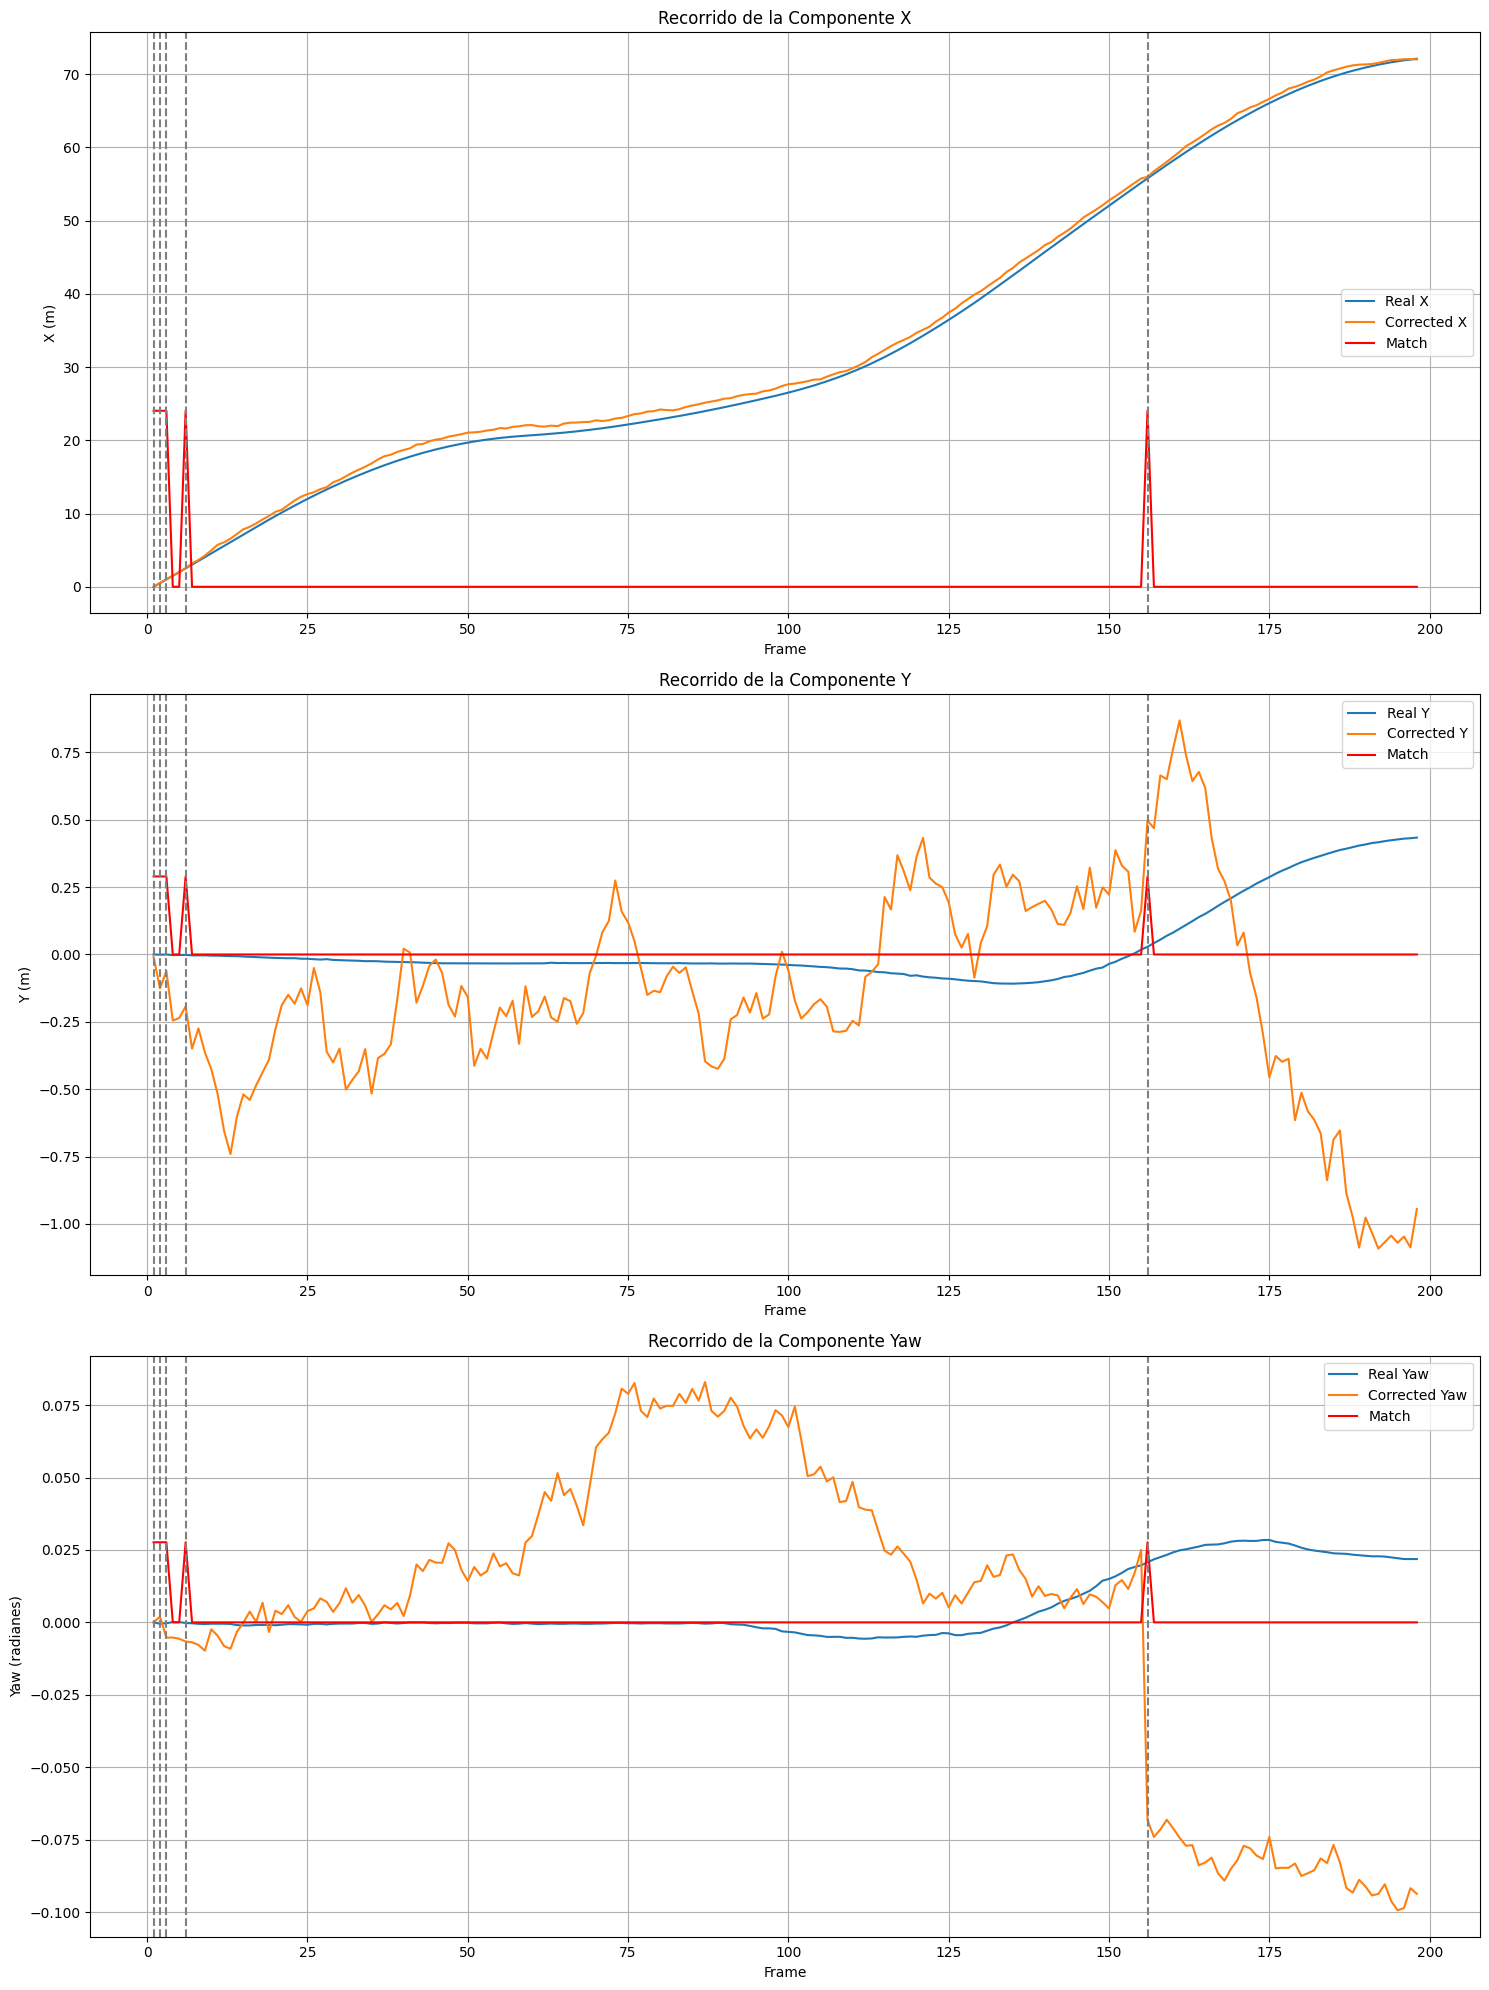

In [31]:
plt.figure(figsize=(15, 20))

# Normalización de los picos de los matches para cada componente
match_scale_x = np.max(poses_data[['real_x', 'corrected_x']].values) / 3
match_scale_y = np.max(poses_data[['real_y', 'corrected_y']].values) / 3
match_scale_yaw = np.max(poses_data[['real_yaw', 'corrected_yaw']].values) / 3

# Plot X component
plt.subplot(3, 1, 1)
plt.plot(poses_data['frame'], poses_data['real_x'], label='Real X')
plt.plot(poses_data['frame'], poses_data['corrected_x'], label='Corrected X')
plt.plot(poses_data['frame'], poses_data['match'] * match_scale_x, color='red', label='Match')
for i, match in enumerate(poses_data['match']):
    if match == 1:
        plt.axvline(x=poses_data['frame'][i], color='gray', linestyle='--')
plt.title('Recorrido de la Componente X')
plt.xlabel('Frame')
plt.ylabel('X (m)')
plt.legend()
plt.grid()

# Plot Y component
plt.subplot(3, 1, 2)
plt.plot(poses_data['frame'], poses_data['real_y'], label='Real Y')
plt.plot(poses_data['frame'], poses_data['corrected_y'], label='Corrected Y')
plt.plot(poses_data['frame'], poses_data['match'] * match_scale_y, color='red', label='Match')
for i, match in enumerate(poses_data['match']):
    if match == 1:
        plt.axvline(x=poses_data['frame'][i], color='gray', linestyle='--')
plt.title('Recorrido de la Componente Y')
plt.xlabel('Frame')
plt.ylabel('Y (m)')
plt.legend()
plt.grid()

# Plot Yaw component
plt.subplot(3, 1, 3)
plt.plot(poses_data['frame'], poses_data['real_yaw'], label='Real Yaw')
plt.plot(poses_data['frame'], poses_data['corrected_yaw'], label='Corrected Yaw')
plt.plot(poses_data['frame'], poses_data['match'] * match_scale_yaw, color='red', label='Match')
for i, match in enumerate(poses_data['match']):
    if match == 1:
        plt.axvline(x=poses_data['frame'][i], color='gray', linestyle='--')
plt.title('Recorrido de la Componente Yaw')
plt.xlabel('Frame')
plt.ylabel('Yaw (radianes)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

Errores de posición y orientación EKF

In [ ]:
mse_x = mean_squared_error(real_positions[:, 0], estimated_positions[:, 0])
mse_y = mean_squared_error(real_positions[:, 1], estimated_positions[:, 1])
mse_position_total = mean_squared_error(real_positions, estimated_positions)

print(f"MSE in position for scene {scene}: {mse_position_total:.4f}")

In [ ]:
mse_ori_yaw = mean_squared_error(real_orientations, estimated_orientations)
mse_orientation_total = mean_squared_error(real_orientations, estimated_orientations)

print(f"MSE in position for scene {scene}: {mse_orientation_total:.4f}")

In [ ]:
print("\nAnálisis de precisión (MSE):")
print(f"MSE Posición en X: {mse_x:.4f}")
print(f"MSE Posición en Y: {mse_y:.4f}")
print(f"MSE Total Posición: {mse_position_total:.4f}")

print(f"MSE Orientación en Yaw: {mse_ori_yaw:.4f}")
print(f"MSE Total Orientación: {mse_orientation_total:.4f}")

In [ ]:
position_errors = (real_positions - estimated_positions) ** 2
orientation_errors = (real_orientations - estimated_orientations) ** 2

In [ ]:
plt.figure(figsize=(15, 20))
# Plot X component
plt.subplot(3, 1, 1)
plt.plot(position_errors[:, 0], label='MSE Posición X')
plt.plot(poses_data['match'] * np.max(position_errors[:, 0]), color='red', label='Match')
plt.title('MSE de Posición X por Iteración')
plt.xlabel('Frame')
plt.ylabel('MSE')
plt.legend()
plt.grid()

# Plot Y component
plt.subplot(3, 1, 2)
plt.plot(position_errors[:, 1], label='MSE Posición Y')
plt.plot(poses_data['match'] * np.max(position_errors[:, 1]), color='red', label='Match')
plt.title('MSE de Posición Y por Iteración')
plt.xlabel('Frame')
plt.ylabel('MSE')
plt.legend()
plt.grid()

# Plot Yaw component
plt.subplot(3, 1, 3)
plt.plot(orientation_errors[:, 0], label='MSE Orientación Yaw')
plt.plot(poses_data['match'] * np.max(orientation_errors[:, 0]), color='red', label='Match')
plt.title('MSE de Orientación Yaw por Iteración')
plt.xlabel('Frame')
plt.ylabel('MSE')
plt.legend()
plt.grid()


plt.tight_layout()
plt.show()

In [ ]:
# Calcular el MSE total para cada iteración
mse_total_ekf = np.mean(position_errors, axis=1)

# Graficar el MSE total por iteración
plt.figure(figsize=(15, 5))
plt.plot(mse_total_ekf, label='MSE EKF Total')
plt.plot(poses_data['match'], color='red', label='Match')
plt.title('MSE Total por Iteración')
plt.xlabel('Iteración')
plt.ylabel('MSE Total')
plt.legend()
plt.grid()
plt.show()

## Análisis del Filtro de Kalman Extendido (EKF)

Los resultados son los siguientes:

- **MSE Posición en X:** 0.0031
- **MSE Posición en Y:** 1.1025
- **MSE Total Posición:** 0.0031
- **MSE Orientación en Yaw:** 0.0011
- **MSE Total Orientación:** 0.0011

### Análisis de Precisión

Se han graficado los errores de posición y orientación por iteración, destacando los puntos donde hay coincidencias con los landmarks.

### MSE Total por Iteración

Se ha calculado y graficado el MSE total para cada iteración, mostrando cómo varía el error a lo largo del tiempo.

### Conclusiones

El análisis muestra que el EKF es capaz de estimar la posición y orientación del vehículo con una precisión razonable. Sin embargo, se observan algunos errores significativos en ciertas iteraciones, lo que sugiere que podría haber mejoras en el modelo o en la calidad de los datos utilizados.